# Historical Components Vis
This was first created on September 7th, 2017 for a group meeting talk with the Karnauskas/Lovenduski group meetings. The purpose is to make an illustrative visual (or series of visuals) to look at each component of the historical FG_CO2 time series so that folks know what I am actually characterizing.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ocn-clim')

# Stats
from scipy import stats
import numpy.polynomial.polynomial as poly

In [34]:
EBU = 'BenCS'

# Load in FG_CO2 and FG_ALT_CO2 data

In [35]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    return ds_forced, ds_residuals, ds_total

In [36]:
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU)
con_mean, con_resid, con_total = load_in_filtered_data('FG_CO2', EBU)

# Compute Each Component
We have four components to visualize here:

1. The historical mean state of the system (level)
2. The seasonal cycle (ensemble mean - trend)
3. The trend (linear trend)
4. The residuals

In [37]:
t = con_total['time'].values
ensemble_mean = con_mean['FG_CO2_AW'].values

# Break down all components
x = np.arange(0, len(t), 1)
coefs = poly.polyfit(x, ensemble_mean, 4)
line_fit = poly.polyval(x, coefs) # This is the trend portion

# Quantifable trend (first order)
slope, _, _, _, _ = stats.linregress(x, ensemble_mean)
slope = slope * len(t)

# I think the "level" or historical state of the system should clearly
# not be the mean of the time series due to the trend. You could either
# just look at the intercept of the linear regression, or the intercept
# of a 4th order polynomial.
b = coefs[0]
level = np.zeros(len(t))
level[:] = b

# Seasonal cycle needs to be detrended, but then scaled back up to the intercept
seasonal_cycle = ensemble_mean - line_fit + b


# Master Plot with Everything Included

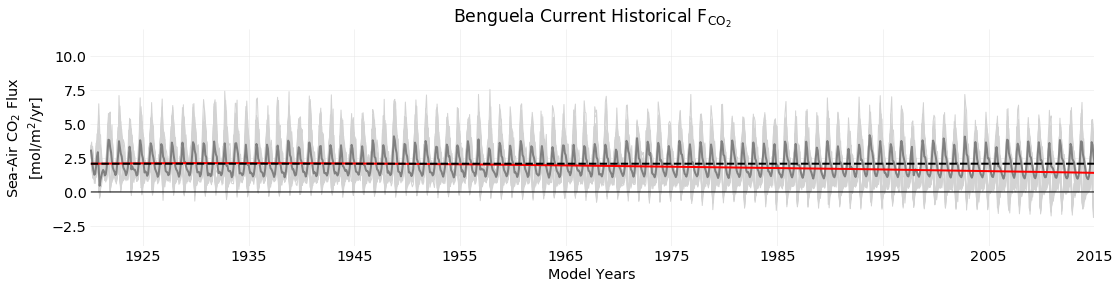

In [41]:
fig = plt.figure(figsize=(18,4))
ax = plt.subplot(111)

# RESIDUALS
for idx in np.arange(0, 34, 1):
    data = con_total['FG_CO2_AW'][:, idx].values
    plt.plot(t, data, color='#D3D3D3', linewidth=1)
    
# SEASONALITY
plt.plot(t, seasonal_cycle, linewidth=2, color='#808080')

# TREND
plt.plot(t, line_fit, color='r', linewidth=2)

# LEVEL
plt.plot(t, level, color='k', linewidth=2, linestyle='--')

# Zero line    
plt.plot(t, np.zeros(len(t)), color='k', linewidth=1)
ax.set(xlim=['1920', '2015'])
ax.set(ylim=[-4, 12])

# Aesthetics
ax.set_title('Benguela Current Historical F$_{\mathrm{CO}_{2}}$')
ax.set_xlabel('Model Years')
ax.set_ylabel('Sea-Air CO$_{2}$ Flux' + '\n' +  '[mol/m$^{2}$/yr]')

#plt.savefig('benguela_historical_characterization.png', transparent=True,
#           bbox_inches='tight', pad_inches=1)